# Questions

- what do I do with the CLS token?

In [1]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import sys
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim
import os
import argparse
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import ImageFile
from tqdm import tqdm
import numpy as np
from dataset import PairedImagesDataset, sample_paired_images
from model import CroDINO, Dinov2Matcher, get_patch_embeddings

In [2]:
# Sample paired images
dataset_path = '/home/lrusso/cvusa'
train_filenames, val_filenames = sample_paired_images(dataset_path, sample_percentage=0.2, split_ratio=0.8, groundtype='cutouts')

# Settings
image_size = 224
aerial_scaling = 2
provide_paths = False

transform_ground = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.CenterCrop((image_size, image_size)),
    transforms.ToTensor()
])

transform_aerial = transforms.Compose([
    transforms.CenterCrop((image_size//aerial_scaling, image_size//aerial_scaling)),
    transforms.ToTensor()
])

# Instantiate the dataset and dataloader
paired_dataset = PairedImagesDataset(train_filenames, transform_aerial=transform_aerial, transform_ground=transform_ground)
data_loader = DataLoader(paired_dataset, batch_size=1, shuffle=True)

# Define the new model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load the Models
repo_name="facebookresearch/dinov2"
model_name="dinov2_vitb14"
model = CroDINO(repo_name, model_name, pretrained=True).to(device)
dino = torch.hub.load(repo_name, model_name).to(device)
print(dino)

pretrained_crodino = False
if pretrained_crodino:
    # Load the trained model state dict
    model_path = 'models/sparse/best_model_epoch_1.pth'
    model_state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(model_state_dict)
    model.eval()

# Load a single pair of images
ground_image, aerial_image = next(iter(data_loader))
ground_image = ground_image.to(device)
aerial_image = aerial_image.to(device)

# Compute the output of the model
output, attention = model(ground_image, aerial_image, return_attention=True)

# Compute the output of the original model
ground_tokens = dino(ground_image)
aerial_tokens = dino(aerial_image)
ground_tokens = get_patch_embeddings(dino, ground_image)
aerial_tokens = get_patch_embeddings(dino, aerial_image)

print("output shape:", output.shape)
print("attention shape: ", attention.shape)
print("ground tokens shape:", ground_tokens.shape)
print("aerial tokens shape:", aerial_tokens.shape)


Using device: cuda


Using cache found in /home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main


torch.Size([1, 1370, 768])


Using cache found in /home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

attention shape:  torch.Size([1, 322, 322])
attention shape:  torch.Size([1, 320, 320])
num_patches_ground:  256
num_patches_aerial:  64
cross_attention_G2A shape:  torch.Size([1, 64, 256])
cross_attention_A2G shape:  torch.Size([1, 256, 64])
reconstructed_ground shape:  torch.Size([1, 256, 768])
reconstructed_aerial shape:  torch.Size([1, 64, 768])
Ground Loss:  2.3072361946105957
Aerial Loss:  1.4261754751205444
Total loss:  3.73341166973114


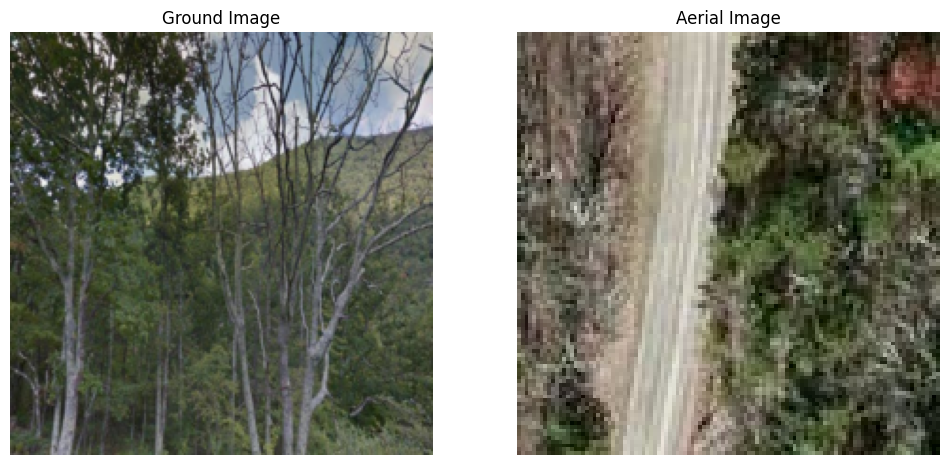

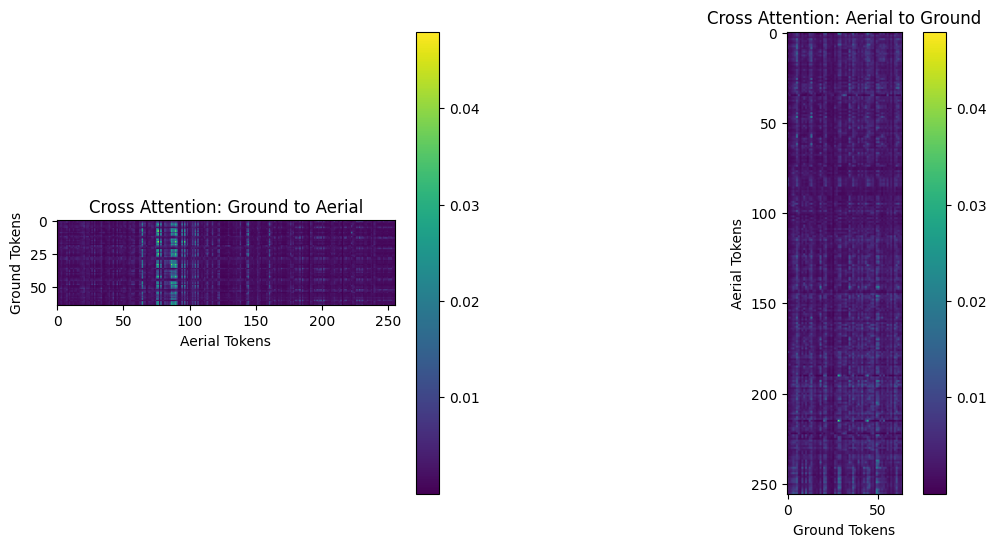

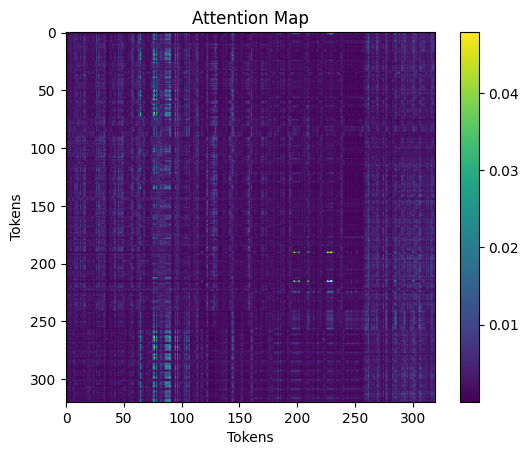

In [3]:
# Visualize the final single-head attention layer
attention = attention.mean(dim=1)  # average across heads only
print("attention shape: ", attention.shape)

# Calculate the number of patches for ground and aerial images
patch_size = model.patch_embed.proj.kernel_size[0]
num_patches_ground = (ground_image.shape[-1] // patch_size) * (ground_image.shape[-2] // patch_size)
num_patches_aerial = (aerial_image.shape[-1] // patch_size) * (aerial_image.shape[-2] // patch_size)

# Crop the Attention - MAGIC TRICK
attention = attention[:, :num_patches_ground + num_patches_aerial, :num_patches_ground + num_patches_aerial]
print("attention shape: ", attention.shape)

# Assuming batch size of 1 for simplicity
cross_attention_A2G = attention[:, :num_patches_ground, num_patches_ground:]
cross_attention_G2A = attention[:, num_patches_ground:, :num_patches_ground]
print("num_patches_ground: ", num_patches_ground)
print("num_patches_aerial: ", num_patches_aerial)
print("cross_attention_G2A shape: ", cross_attention_G2A.shape)
print("cross_attention_A2G shape: ", cross_attention_A2G.shape)

# Reconstruct the images from the tokens
reconstructed_aerial = torch.matmul(cross_attention_G2A, ground_tokens)
reconstructed_ground = torch.matmul(cross_attention_A2G, aerial_tokens)
print("reconstructed_ground shape: ", reconstructed_ground.shape)
print("reconstructed_aerial shape: ", reconstructed_aerial.shape)

# Compute MSE loss
criterion = nn.MSELoss()
loss_ground = criterion(reconstructed_ground, ground_tokens)
loss_aerial = criterion(reconstructed_aerial, aerial_tokens)
print("Ground Loss: ", loss_ground.item())
print("Aerial Loss: ", loss_aerial.item())
print("Total loss: ", loss_ground.item() + loss_aerial.item())

# Convert tensors to numpy
cross_attention_G2A = cross_attention_G2A.cpu().detach().numpy()
cross_attention_A2G = cross_attention_A2G.cpu().detach().numpy()

# Convert images to numpy for visualization
ground_image_np = ground_image.squeeze().permute(1, 2, 0).detach().cpu().numpy()
aerial_image_np = aerial_image.squeeze().permute(1, 2, 0).detach().cpu().numpy()

# Plot the ground image and aerial image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(ground_image_np)
ax[0].set_title("Ground Image")
ax[0].axis('off')
ax[1].imshow(aerial_image_np)
ax[1].set_title("Aerial Image")
ax[1].axis('off')
plt.show()

# Determine common vmin and vmax for color scales
vmin = min(cross_attention_G2A.min(), cross_attention_A2G.min())
vmax = max(cross_attention_G2A.max(), cross_attention_A2G.max())

# Plot the cross-attention maps with common color scale
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
img0 = ax[0].imshow(cross_attention_G2A.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
ax[0].set_title("Cross Attention: Ground to Aerial")
ax[0].set_xlabel("Aerial Tokens")
ax[0].set_ylabel("Ground Tokens")
fig.colorbar(img0, ax=ax[0])
img1 = ax[1].imshow(cross_attention_A2G.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
ax[1].set_title("Cross Attention: Aerial to Ground")
ax[1].set_xlabel("Ground Tokens")
ax[1].set_ylabel("Aerial Tokens")
fig.colorbar(img1, ax=ax[1])
plt.show()

# Visualize the whole attention map with common color scale
plt.imshow(attention.squeeze().detach().cpu().numpy(), cmap='viridis', vmin=vmin, vmax=vmax)
plt.title("Attention Map")
plt.xlabel("Tokens")
plt.ylabel("Tokens")
plt.colorbar()
plt.show()

Using cache found in /home/lrusso/.cache/torch/hub/facebookresearch_dinov2_main


tokens1.shape (1024, 768)
token2.shape (1024, 768)
reduced_tokens.shape (2048, 3)
ground_image.shape: torch.Size([1, 3, 224, 224])
aerial_image.shape: torch.Size([1, 3, 112, 112])
image_tensor1.shape: torch.Size([3, 448, 448])
image_tensor2.shape: torch.Size([3, 448, 448])
grid_size1: (32, 32)
grid_size2: (32, 32)
resize_scale1: 0.5
resize_scale2: 0.25


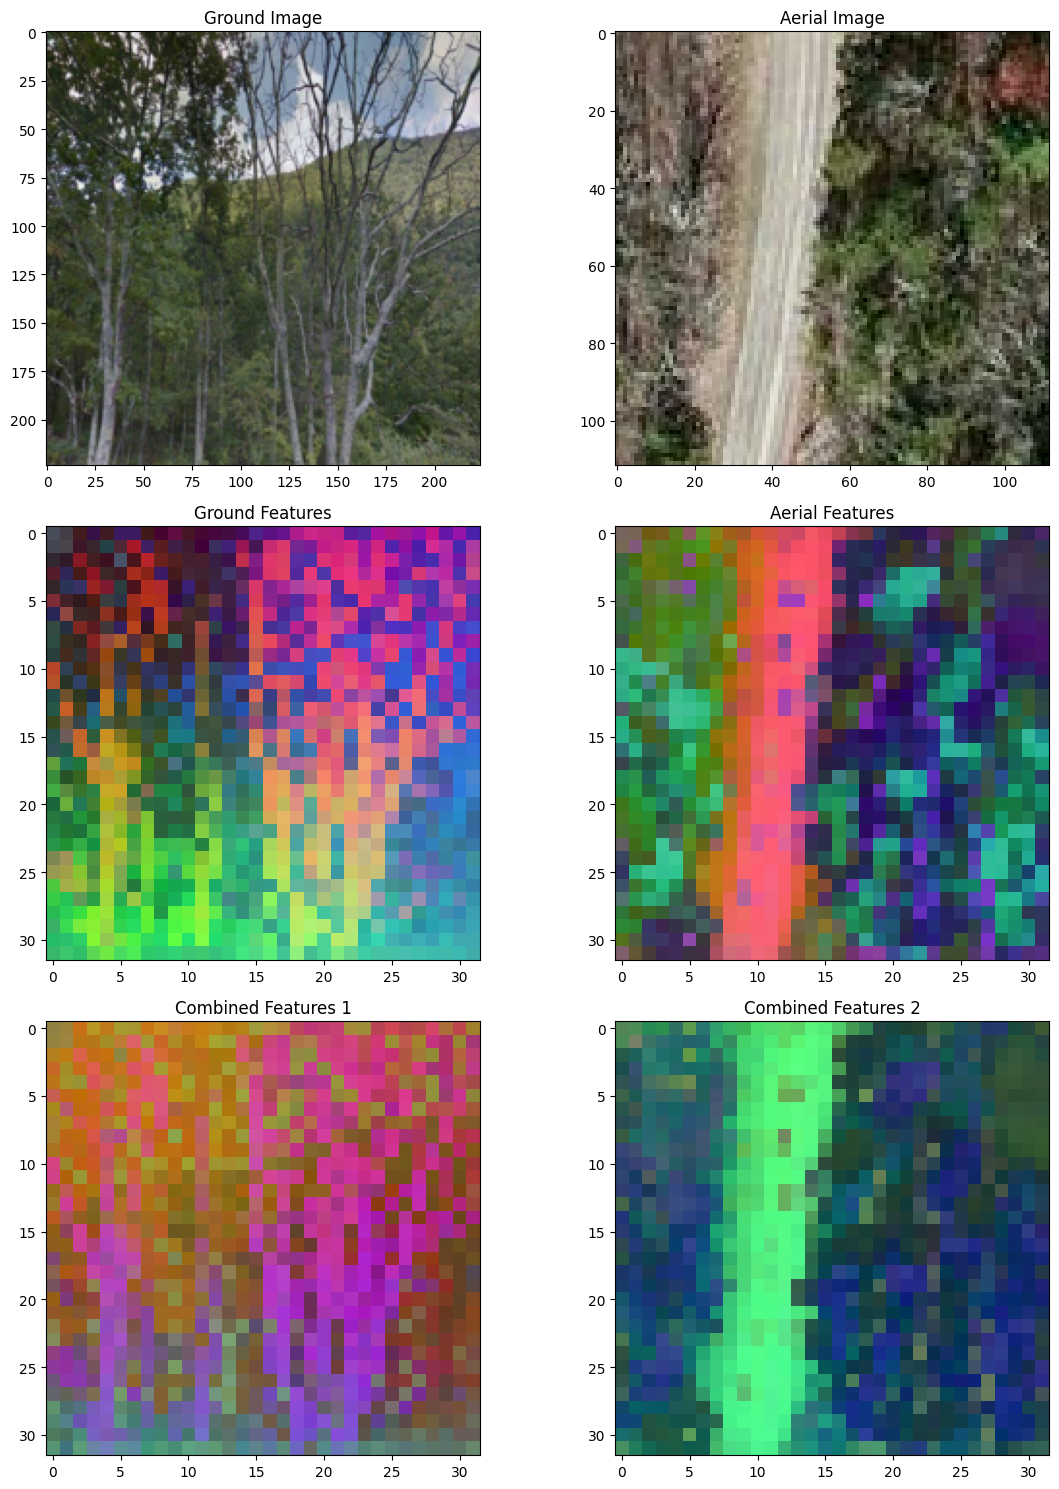

In [4]:
# Convert to NumPy array for processing
ground_image_vis = ground_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255
aerial_image_vis = aerial_image.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255
ground_image_vis = ground_image_vis.astype(np.uint8)
aerial_image_vis = aerial_image_vis.astype(np.uint8)

# Init Dinov2Matcher
dm = Dinov2Matcher(half_precision=False)

# Extract features
image_tensor1, grid_size1, resize_scale1 = dm.prepare_image(ground_image_vis)
features1 = dm.extract_features(image_tensor1)

image_tensor2, grid_size2, resize_scale2 = dm.prepare_image(aerial_image_vis)
features2 = dm.extract_features(image_tensor2)

# Visualization
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 15))
ax1.imshow(ground_image_vis)
ax1.set_title('Ground Image')
ax2.imshow(aerial_image_vis)
ax2.set_title('Aerial Image')
vis_image1 = dm.get_embedding_visualization(features1, grid_size1)
ax3.imshow(vis_image1)
ax3.set_title('Ground Features')
vis_image2 = dm.get_embedding_visualization(features2, grid_size2)
ax4.imshow(vis_image2)
ax4.set_title('Aerial Features')
vis_combined1, vis_combined2 = dm.get_combined_embedding_visualization(features1, features2, grid_size1, grid_size2)
ax5.imshow(vis_combined1)
ax5.set_title('Combined Features 1')
ax6.imshow(vis_combined2)
ax6.set_title('Combined Features 2')
fig.tight_layout()

# More info
print("ground_image.shape:", ground_image.shape)
print("aerial_image.shape:", aerial_image.shape)
print("image_tensor1.shape:", image_tensor1.shape)
print("image_tensor2.shape:", image_tensor2.shape)
print("grid_size1:", grid_size1)
print("grid_size2:", grid_size2)
print("resize_scale1:", resize_scale1)
print("resize_scale2:", resize_scale2)

normalized_features1.shape: (1024, 768)
normalized_features2.shape: (1024, 768)
Selected index from aerial features:  383


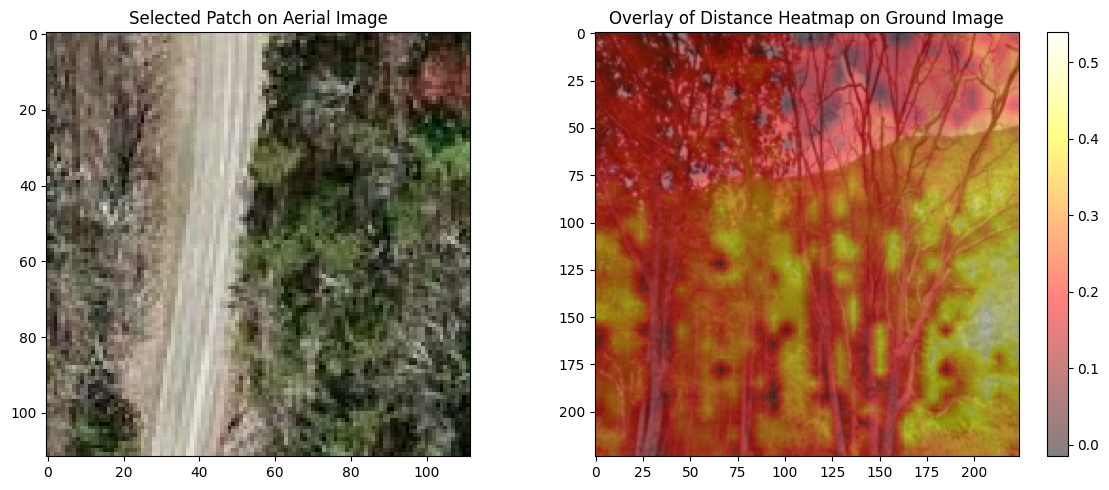

In [5]:
from sklearn.preprocessing import normalize

# Normalize the features
normalized_features1 = normalize(features1, axis=1)
normalized_features2 = normalize(features2, axis=1)
print("normalized_features1.shape:", normalized_features1.shape)
print("normalized_features2.shape:", normalized_features2.shape)

# Take one element from features2 (aerial image features)
random_index = np.random.randint(0, features2.shape[0])
selected_feature = normalized_features2[random_index]
print("Selected index from aerial features: ", random_index)

# Show which small piece of the aerial image was chosen
row_aerial, col_aerial = dm.idx_to_source_position(random_index, grid_size2, resize_scale2)
selected_patch_size = dm.model.patch_size * resize_scale2

# Compute the distance (inner product) between this element and all elements of features1 (ground image features)
distances = np.dot(normalized_features1, selected_feature)

# Reshape into the appropriate dimensions for the ground image
reshaped_distances = distances.reshape(grid_size1)

# Resize the heatmap to fit the ground image
resized_heatmap = cv2.resize(reshaped_distances, (ground_image_vis.shape[1], ground_image_vis.shape[0]))

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(aerial_image_vis)
rect = plt.Rectangle((col_aerial - selected_patch_size / 2, row_aerial - selected_patch_size / 2),
                     selected_patch_size, selected_patch_size,
                     linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)
ax1.set_title('Selected Patch on Aerial Image')
alpha = 0.5
ax2.imshow(ground_image_vis)
img2 = ax2.imshow(resized_heatmap, cmap='hot', interpolation='nearest', alpha=alpha)
fig.colorbar(img2, ax=ax2)
ax2.set_title('Overlay of Distance Heatmap on Ground Image')
fig.tight_layout()